# Replaying Old Data

- Work under a separate branch with git (i.e. git checkout -b my-new-branch)

- Make a new folder in Projects (for your specific purposes)

- Copy this ipynb file that folder

- The data is stored on L-Drive

- the main gist of re-playing existing data is:
    - that your first load everything into a big matrix with mne
    - then initialize a specific **amp** (i.e., the "replayamp")
    - then do exactly the same as normal, with a while True loop with calls to amp.get_data()
    

In [1]:
# import all the needed stuff:

import time
import sys
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

import easygui  # popup windows with buttons made easy
import mne  # EEGLAB for python
from IPython.display import clear_output  # to clear the cell output during while loop
import re  # regular expressions
import pickle  # to save/load data
import dynarray  # a growing numpy array

import logging
logging.basicConfig(level=logging.ERROR)

sys.path.append("../../mushu")  # driver for the amps
sys.path.append("../../mushu/libmushu")
import libmushu

sys.path.append("../../nftools")  # handy stuff needed for NF
from nftools.loopcontrol import LoopState
from nftools.analysis import convert_alld_allm_to_mne
from nftools.analysis import select_part_from_mne_dataset
from nftools.analysis import plot_compare_two_spectra


sys.path.append("../../wyrm")  # real-time data analysis
from wyrm.types import RingBuffer
from wyrm.types import BlockBuffer
from wyrm import io
from wyrm import processing as proc

import scipy
from scipy import signal

from collections import deque  # a FILO list useful for plotting!

In [2]:
# this is the replay notebook - so select a file for playback - this is for brainvision files.

fn=easygui.fileopenbox(default='/media/ldrive/Lab_MichaelB/Johan/nf/rawdata/*.vhdr')
print(fn)

raw_fromfile = mne.io.read_raw_brainvision(fn)
montage=mne.channels.read_montage('standard_1005', ch_names=raw_fromfile.ch_names)  # always use MNE definitions
raw_fromfile.set_montage(montage)

/media/ldrive/Lab_MichaelB/Johan/nf/rawdata/CH005/eeg/CHall_S05_2018-10-17_16-06-53.vhdr
Extracting parameters from /media/ldrive/Lab_MichaelB/Johan/nf/rawdata/CH005/eeg/CHall_S05_2018-10-17_16-06-53.vhdr...
Setting channel info structure...
Currently, 1 trigger(s) will be dropped, such as [Impedance]. Consider using ``event_id`` to parse triggers that do not follow the 'S###' pattern.
The following EEG sensors did not have a position specified in the selected montage: ['EOG']. Their position has been left untouched.


<ipython-input-2-b397cd66af22>:6: RuntimeWarning: Currently, 1 trigger(s) will be dropped, such as [Impedance]. Consider using ``event_id`` to parse triggers that do not follow the 'S###' pattern.
  raw_fromfile = mne.io.read_raw_brainvision(fn)
<ipython-input-2-b397cd66af22>:8: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['EOG']. Their position has been left untouched.
  raw_fromfile.set_montage(montage)


<RawBrainVision  |  CHall_S05_2018-10-17_16-06-53.eeg, n_channels x n_times : 65 x 1334386 (667.2 sec), ~164 kB, data not loaded>

In [ ]:
# this is the replay notebook - so select a file for playback - this is for eeglab files.

fn=easygui.fileopenbox(default='*.set')
print(fn)

raw_fromfile = mne.io.read_raw_eeglab(fn)
montage=mne.channels.read_montage('standard_1005', ch_names=raw_fromfile.ch_names)  # always use MNE definitions
raw_fromfile.set_montage(montage)

In [3]:
# properties of the recording, and what we're doing here:
fs = raw_fromfile.info['sfreq']
nbchan = raw_fromfile.info['nchan']-1

updateTime = 0.1  # run some kind of calculation every X seconds
buffSize = 1.0  # run calculation on last X seconds of data

In [30]:
%matplotlib widget  
plt.ion()  # enable widget plots & interactive plots

time_in_plot=2.0
sy1=deque(np.zeros(round(fs * time_in_plot)), round(fs * time_in_plot))  # for plotting - the FILO list
sy2=deque(np.zeros(round(fs * time_in_plot)), round(fs * time_in_plot))  # for plotting - the FILO list

channel_to_plot=10
sx = np.linspace(0, time_in_plot, round(fs * time_in_plot))

featuresy1 = deque(np.zeros(round(1/updateTime * time_in_plot)), round(1/updateTime * time_in_plot))
featuresx = np.linspace(0, time_in_plot, round(1/updateTime * time_in_plot))


In [5]:
# real-time data filtering -- high-pass filter (of 1.0 Hz)

f_low = 1.0
# f_high = 15.0
butter_ord = 3
lenchannels = 64

#rt_b, rt_a = signal.butter(butter_ord, [f_low / fn, f_high / fn], btype='band')
rt_b_hp, rt_a_hp = signal.butter(butter_ord, 2*f_low/fs, btype='high', analog=False)  # a digital high-pass filter
rt_zi_hp = proc.lfilter_zi(rt_b_hp, rt_a_hp, lenchannels)


In [6]:
# real-time data filtering -- band-pass filter (of 12.0 - 15.0 Hz)

f_low = 12.0
f_high = 15.0
butter_ord = 3
lenchannels = 64

#rt_b, rt_a = signal.butter(butter_ord, [f_low / fn, f_high / fn], btype='band')
rt_b_bp, rt_a_bp = signal.butter(butter_ord, [2*f_low/fs, 2*f_high/fs], btype='band', analog=False)  # a digital high-pass filter
rt_zi_bp = proc.lfilter_zi(rt_b_bp, rt_a_bp, lenchannels)

In [7]:
# prepare data for replay (warning: need probably a lot of memory)

mul_factor = 1.0
if 1e-6 in [raw_fromfile.info['chs'][0]['cal'], raw_fromfile.info['chs'][0]['range']]:
    mul_factor = 1.0 / 1e-6

seed_d=raw_fromfile[:-1,:][0] * mul_factor  # scale the data to seed (so no 1e-6 stuff in the replayed data)
seed_d=np.array(seed_d.transpose())
seed_ch=raw_fromfile.ch_names[0:-1]
seed_fs=raw_fromfile.info['sfreq']

# prepare for replay; markers:
seed_mdata=np.transpose(raw_fromfile[-1,:][0])
seed_m=[[i / raw_fromfile.info['sfreq'] * 1000, int(m[0])] for i, m in enumerate(seed_mdata) if m > 0] 

In [8]:
amp = libmushu.get_amp('replayamp')
amp.configure(seed_d, seed_m, seed_ch, seed_fs, realtime=True, blocksize_samples=100)

In [9]:
alld=dynarray.DynamicArray((None, len(amp.get_channels())))     # data
allm=[]     # markers
sfreq = amp.get_sampling_frequency()  # sampling frequency
ch_names=amp.get_channels()  # channel names

markTime=time.time()


rb = RingBuffer(buffSize * 1000)  # the buffer containing the last X seconds of data - declared in MILISECONDS
totalTime = seed_d.shape[0]/raw_fromfile.info['sfreq']

In [12]:
amp.start()

In [14]:
fig=plt.figure()  # plotting...
th=fig.suptitle('')
ah1=fig.add_subplot(121)
ah2=fig.add_subplot(122)
l1, = ah1.plot(sx, sy1)
l2, = ah2.plot(sx, sy2)

featurefig = plt.figure()
featureth=fig.suptitle('')
featureah=featurefig.add_subplot(111)
featurel1, = featureah.plot(featuresx, featuresy1)



# l=LoopState(); l.start()
markeroffset = 0  # needed to store all data in one big mat/vector
t0=time.time()
curTime=time.time()
st=''
while curTime - t0 < totalTime:  # l.get_state() != 'Stop':
   
    
    # keep track of time:
    curTime = time.time()
    
    # this is where you get the data
    data, marker = amp.get_data()
    
    if data.shape[0] > 0:  # this is crucual for remembering filter state.

        cnt = io.convert_mushu_data(data, marker, sfreq, ch_names)

        f_cnt, rt_zi_bp = proc.lfilter(cnt, rt_b_bp, rt_a_bp, zi=rt_zi_bp)  # real-time data preprocessing...

        # plotting...
        sy1.extend(cnt.data[:,channel_to_plot])  # to visualize/plot -- s1 and s2 are deque's
        sy2.extend(f_cnt.data[:,channel_to_plot])
        l1.set_ydata(sy1)
        l2.set_ydata(sy2)
        msy1=np.mean(sy1)
        msy2=np.mean(sy2)
        ah1.set_ylim(-100+msy1, 100+msy1)
        ah2.set_ylim(-10+msy2, 10+msy2)

        fig.canvas.draw()
        fig.canvas.flush_events()
        
        newsamples = cnt.data.shape[0]

        rb.append(f_cnt)

        # append it to the big matrix
        alld.extend(data)
        for m in marker:
            allm.append([m[0] + markeroffset, m[1]])
        markeroffset += newsamples / float(sfreq) * 1000.
        


        # do the following every 0.1 msec - with with the ringbuffer:
        if curTime - markTime > updateTime:
            # do Stuff

            markTime = curTime
            # 1) obtain last 1-second(s)
            d = rb.get()

            # thomas does stuff here


            # we send the value to BCI/STIM



            clear_output(wait=True)  # write some logging information here
            str1 = 'Playing Back - time = %f' % (curTime - t0)
            str2 = 'Length Markers: %d' % len(allm)
            str3 = '%d, %d' % data.shape
            #print('Playing Back - time = %f' % (curTime - t0))
            #print('Length Markers: %d' % len(allm))
            # print(data.shape)
            th.set_text(str1 + '\n' + str2 + '\n' +str3)





FigureCanvasNbAgg()

In [15]:
amp.stop()
alld.shrink_to_fit()

amplifier stopped!


In [16]:
# write to disk, so we can re-load it later:

t={'alld':alld, 'allm':allm, 'ch_names':ch_names, 'sfreq':sfreq}
with open('c-allm-and-alld.pkl', 'wb') as f:
    pickle.dump(t, f)

In [2]:
# load from disk:

with open('c-allm-and-alld.pkl','rb') as f:
    t=pickle.load(f)
for key in t.keys():
    locals()[key] = t[key]

In [17]:
raw = convert_alld_allm_to_mne(alld, allm, ch_names, sfreq)  # covert to MNE
raw.resample(1000)

The following EEG sensors did not have a position specified in the selected montage: ['EOG']. Their position has been left untouched.


../../nftools/nftools/analysis.py:31: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['EOG']. Their position has been left untouched.
  montage=montage


Creating RawArray with float64 data, n_channels=64, n_times=1334286
    Range : 0 ... 1334285 =      0.000 ...   667.143 secs
Ready.
2000.0
Creating RawArray with float64 data, n_channels=1, n_times=1334286
    Range : 0 ... 1334285 =      0.000 ...   667.143 secs
Ready.
2556 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  22  23  31
  40  41  42  45  46  48  51  52  55  56  60  64  81  82  83  84 128 131
 132 133 134 201 202 203 204 221 222 223 224 225 226 227 228 229 231 232
 233 234 241 242 243 244 245 246 247]
2556 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  22  23  31
  40  41  42  45  46  48  51  52  55  56  60  64  81  82  83  84 128 131
 132 133 134 201 202 203 204 221 222 223 224 225 226 227 228 229 231 232
 233 234 241 242 243 244 245 246 247]


<RawArray  |  None, n_channels x n_times : 65 x 667143 (667.1 sec), ~331.0 MB, data loaded>

In [20]:
%matplotlib qt5

FigureCanvasNbAgg()

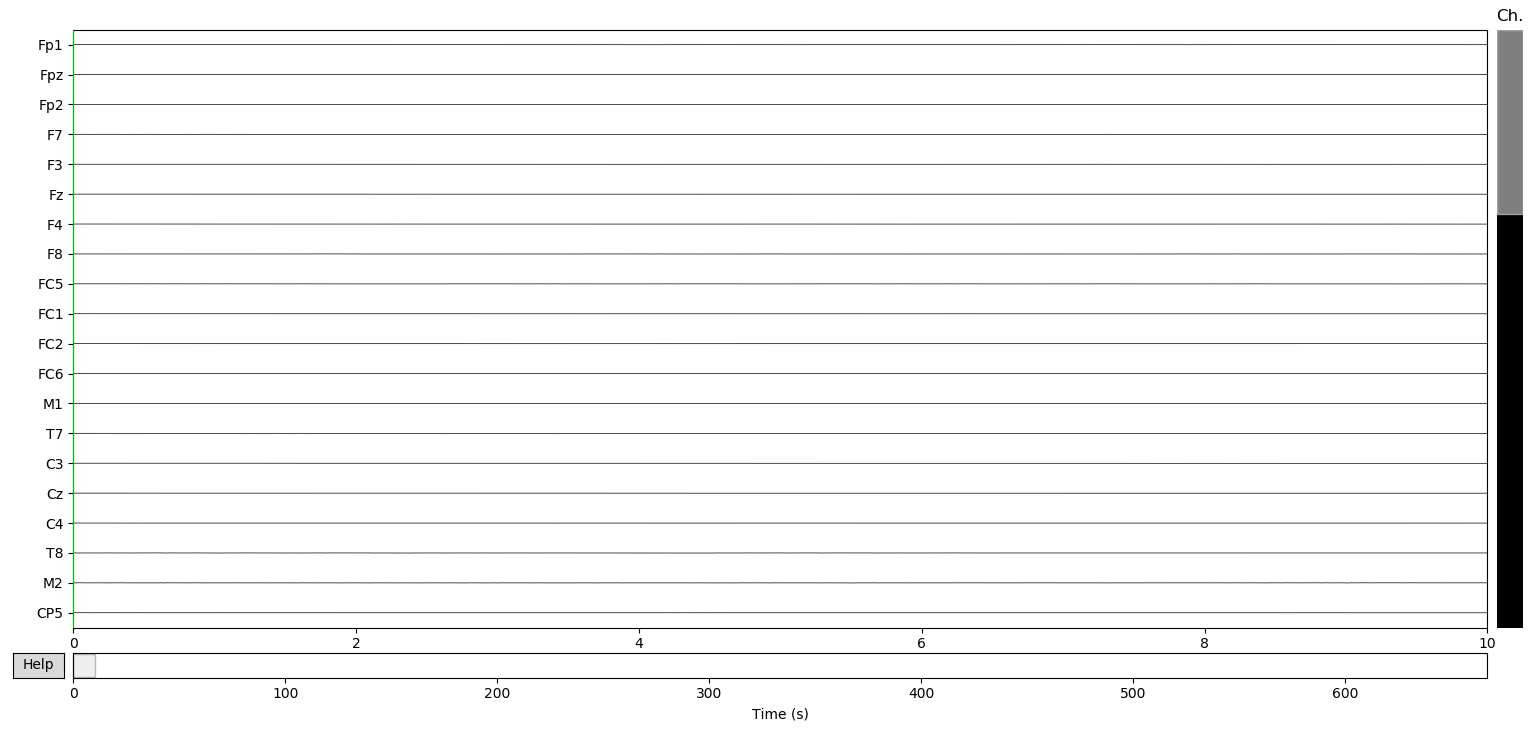

In [21]:
raw.plot(scalings='auto')

In [ ]:
# raw.set_eeg_reference(ref_channels='average')
# better not (yet) - before removing bad channels, since these mess up your data big time: see PREP paper:


In [22]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                       stim=False, exclude='bads')

raw.notch_filter(np.arange(50, 300, 50), picks=picks, filter_length='auto', phase='zero')
# add it (potentialy) some other preprocessing steps here

Setting up band-stop filter
Filter length of 6601 samples (6.601 sec) selected


<RawArray  |  None, n_channels x n_times : 65 x 667143 (667.1 sec), ~331.0 MB, data loaded>

In [23]:
# split data sets between EO and EC

newraw_eo=select_part_from_mne_dataset(raw, markers=[201, 202])
newraw_ec=select_part_from_mne_dataset(raw, markers=[203, 204])

using markers
2556 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  22  23  31
  40  41  42  45  46  48  51  52  55  56  60  64  81  82  83  84 128 131
 132 133 134 201 202 203 204 221 222 223 224 225 226 227 228 229 231 232
 233 234 241 242 243 244 245 246 247]
using boundaries
[[-1.85723940e+03 -1.87699606e+03 -1.87469613e+03 ...  6.29810168e+01
   6.30667301e+01  6.58265217e+01]
 [-5.28433740e+02 -5.49596949e+02 -5.49917857e+02 ...  8.03922543e+01
   7.88920103e+01  8.12687200e+01]
 [-7.06091056e+02 -7.30325705e+02 -7.39780006e+02 ...  8.60222999e+01
   8.60322093e+01  8.89364757e+01]
 ...
 [ 2.18940192e+01  1.66587592e+01  3.08331834e+01 ...  8.07299692e+00
   5.07024133e+00  6.03662706e+00]
 [-7.45315553e+00 -6.71290893e+00  1.49029694e+01 ...  3.30432153e+00
   4.17951059e+00  5.11969391e+00]
 [ 2.00967859e+02 -3.21394305e-02 -3.21375029e-02 ...  1.60716409e-02
   1.60735698e-02  1.60754987e-02]]
Creating RawArray with float64 data, n_channels

In [24]:
d1=plot_compare_two_spectra(newraw_eo, newraw_ec, freqs=[1, 25], n_fft=2048, n_overlap=512, chs_to_include=['Oz','O1','O2','PO8', 'PO7'], freq_lims_topoplot=[7, 12], pow_lims = [-10, 25])


Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
['Oz', 'O1', 'O2', 'PO8', 'PO7']
[29, 30, 60, 61, 62]


FigureCanvasNbAgg()

In [25]:
plt.figure();plt.plot(newraw_eo[0,0:1000][0].transpose())

FigureCanvasNbAgg()

FigureCanvasNbAgg()

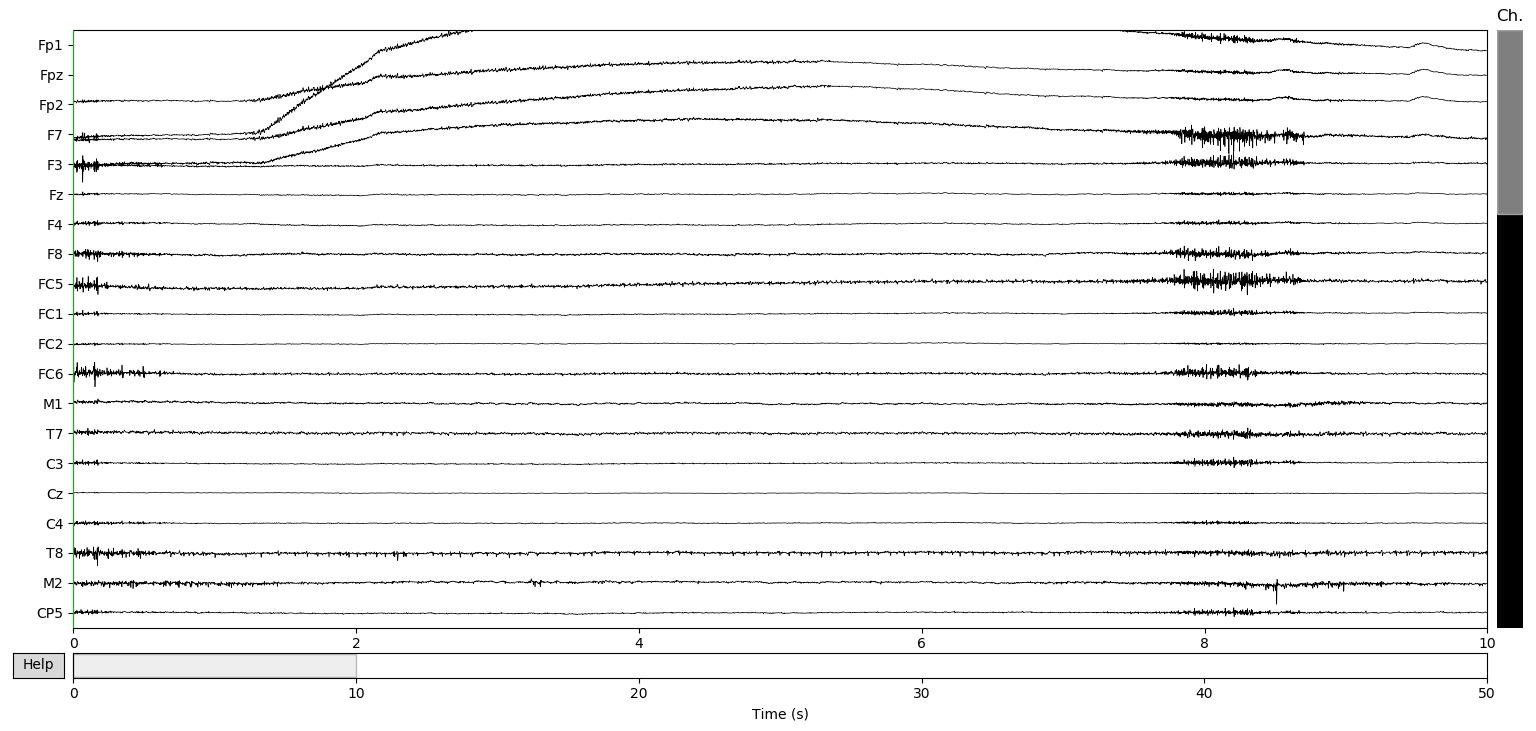

In [26]:
newraw_eo.plot(scalings='auto')

/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


FigureCanvasNbAgg()

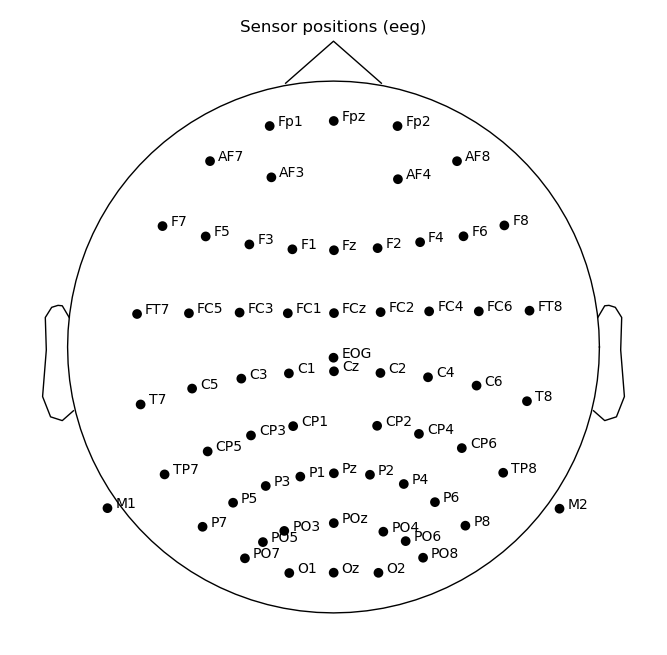

In [27]:
mne.viz.plot_sensors(newraw_ec.info, show_names=True)

In [29]:
%matplotlib qt5

FigureCanvasNbAgg()

Effective window size : 2.048 (s)


/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/mne/viz/evoked.py:162: RuntimeWarning: invalid value encountered in maximum
  rgb /= np.maximum(rgb.max(0), 1e-16)  # avoid div by zero
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/home/johan/.conda/envs/rt/lib/python3.6/site-packag

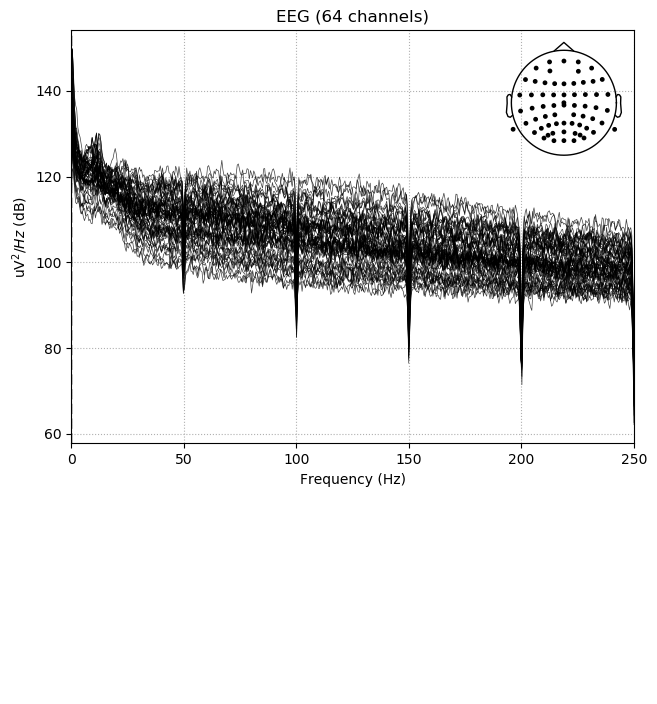

In [28]:
newraw_ec.plot_psd(tmax=np.inf, fmax=250, n_fft=2048)

In [ ]:
# some attempts at doing ICA
from mne.preprocessing import ICA
method = 'fastica'
n_components = 25
decim = 3
random_state = 23
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

picks_eeg = mne.pick_types(newraw_ec.info, meg=False, eeg=True, eog=False,
                           stim=False, exclude='bads')
reject = dict(eeg=1e-3)
ica.fit(newraw_ec, picks=picks_eeg, decim=decim, reject=reject)
print(ica)